In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import gc
import wandb
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score
from mamba_ssm import Mamba2
import matplotlib.pyplot as plt
import pickle

/home/joao/Documents/Star-Classifier/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class MultiModalBalancedMultiLabelDataset(Dataset):
    """
    A balanced multi-label dataset that returns (X_spectra, X_gaia, y).
    It uses the same balancing strategy as `BalancedMultiLabelDataset`.
    """
    def __init__(self, X_spectra, X_gaia, y, limit_per_label=201):
        """
        Args:
            X_spectra (torch.Tensor): [num_samples, num_spectra_features]
            X_gaia (torch.Tensor): [num_samples, num_gaia_features]
            y (torch.Tensor): [num_samples, num_classes], multi-hot labels
            limit_per_label (int): limit or target number of samples per label
        """
        self.X_spectra = X_spectra
        self.X_gaia = X_gaia
        self.y = y
        self.limit_per_label = limit_per_label
        self.num_classes = y.shape[1]
        self.indices = self.balance_classes()
        
    def balance_classes(self):
        indices = []
        class_counts = torch.sum(self.y, axis=0)
        for cls in range(self.num_classes):
            cls_indices = np.where(self.y[:, cls] == 1)[0]
            if len(cls_indices) < self.limit_per_label:
                if len(cls_indices) == 0:
                    # No samples for this class
                    continue
                extra_indices = np.random.choice(
                    cls_indices, self.limit_per_label - len(cls_indices), replace=True
                )
                cls_indices = np.concatenate([cls_indices, extra_indices])
            elif len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        indices = np.unique(indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return (
            self.X_spectra[index],  # spectra features
            self.X_gaia[index],     # gaia features
            self.y[index],          # multi-hot labels
        )
def calculate_class_weights(y):
    if y.ndim > 1:  
        class_counts = np.sum(y, axis=0)  
    else:
        class_counts = np.bincount(y)

    total_samples = y.shape[0] if y.ndim > 1 else len(y)
    class_counts = np.where(class_counts == 0, 1, class_counts)  # Prevent division by zero
    class_weights = total_samples / (len(class_counts) * class_counts)
    
    return class_weights
def calculate_metrics(y_true, y_pred):
    metrics = {
        "micro_f1": f1_score(y_true, y_pred, average='micro'),
        "macro_f1": f1_score(y_true, y_pred, average='macro'),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted'),
        "micro_precision": precision_score(y_true, y_pred, average='micro', zero_division=1),
        "macro_precision": precision_score(y_true, y_pred, average='macro', zero_division=1),
        "weighted_precision": precision_score(y_true, y_pred, average='weighted', zero_division=1),
        "micro_recall": recall_score(y_true, y_pred, average='micro'),
        "macro_recall": recall_score(y_true, y_pred, average='macro'),
        "weighted_recall": recall_score(y_true, y_pred, average='weighted'),
        "hamming_loss": hamming_loss(y_true, y_pred)
    }
    
    # Check if there are at least two classes present in y_true
    #if len(np.unique(y_true)) > 1:
        #metrics["roc_auc"] = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    #else:
       # metrics["roc_auc"] = None  # or you can set it to a default value or message
    
    return metrics


In [5]:
def train_model_fusion(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=100,
    lr=1e-4,
    max_patience=20,
    device='cuda'
):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=int(max_patience / 5)
    )

    # We assume the datasets are MultiModalBalancedMultiLabelDataset
    # that returns (X_spectra, X_gaia, y).
    # You can keep the class weighting logic as in train_model_mamba.
    all_labels = []
    for _, _, y_batch in train_loader:
        all_labels.extend(y_batch.cpu().numpy())
    
    class_weights = calculate_class_weights(np.array(all_labels))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    
    best_val_loss = float('inf')
    patience = max_patience

    for epoch in range(num_epochs):
        # Resample training data
        train_loader.dataset.re_sample()

        # Recompute class weights if needed
        all_labels = []
        for _, _, y_batch in train_loader:
            all_labels.extend(y_batch.cpu().numpy())
        class_weights = calculate_class_weights(np.array(all_labels))
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

        # --- Training ---
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for X_spc, X_ga, y_batch in train_loader:
            X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_spc, X_ga)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_spc.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct = (predicted == y_batch).float()
            train_acc += correct.mean(dim=1).mean().item()

        # --- Validation ---
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for X_spc, X_ga, y_batch in val_loader:
                X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
                outputs = model(X_spc, X_ga)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_spc.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct = (predicted == y_batch).float()
                val_acc += correct.mean(dim=1).mean().item()

        # --- Test metrics (optional or do after training) ---
        test_loss, test_acc = 0.0, 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_spc, X_ga, y_batch in test_loader:
                X_spc, X_ga, y_batch = X_spc.to(device), X_ga.to(device), y_batch.to(device)
                outputs = model(X_spc, X_ga)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_spc.size(0)
                
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct = (predicted == y_batch).float()
                test_acc += correct.mean(dim=1).mean().item()

                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # Compute multi-label metrics as before
        all_metrics = calculate_metrics(np.array(y_true), np.array(y_pred))

        # Logging example
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader.dataset),
            "val_loss": val_loss / len(val_loader.dataset),
            "train_acc": train_acc / len(train_loader),
            "val_acc": val_acc / len(val_loader),
            "test_loss": test_loss / len(test_loader.dataset),
            "test_acc": test_acc / len(test_loader),
            **all_metrics
        })

        # Scheduler
        scheduler.step(val_loss / len(val_loader.dataset))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = max_patience
            best_model = model.state_dict()
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model

In [6]:
# --------------------------
# Modified CrossAttentionBlock
# --------------------------
class CrossAttentionBlock(nn.Module):
    """
    A simple cross-attention block with a feed-forward sub-layer.
    Stores the attention weights from the multi-head attention in an attribute.
    """
    def __init__(self, d_model, n_heads=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model, 
            num_heads=n_heads, 
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        
        # Attribute to store the attention weights for later inspection
        self.last_attn_weights = None

    def forward(self, x_q, x_kv):
        """
        Args:
            x_q  : (batch_size, seq_len_q, d_model)
            x_kv : (batch_size, seq_len_kv, d_model)
        """
        # Compute cross-attention and capture the attention weights
        attn_output, attn_weights = self.cross_attn(query=x_q, key=x_kv, value=x_kv)
        self.last_attn_weights = attn_weights  # shape: (batch_size, n_heads, seq_len_q, seq_len_kv)
        
        x = self.norm1(x_q + attn_output)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


In [7]:
# --------------------------
# Modified StarClassifierFusion with an initial cross-attention block
# --------------------------
class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra,
        d_model_gaia,
        num_classes,
        input_dim_spectra,
        input_dim_gaia,
        n_layers=6,
        use_cross_attention=True,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """
        super().__init__()
        

        # --- MAMBA 2 for spectra ---
        self.mamba_spectra = nn.Sequential(
            *[Mamba2(
                d_model=d_model_spectra,
                d_state=64,
                d_conv=4,
                expand=2,
                use_mem_eff_path=False, # Disable memory-efficient path that requires wierd reshaping
            ) for _ in range(n_layers)]
        )
        self.input_proj_spectra = nn.Linear(1, d_model_spectra)


        # --- MAMBA 2 for gaia ---
        self.mamba_gaia = nn.Sequential(
            *[Mamba2(
                d_model=d_model_gaia,
                d_state=64,
                d_conv=4,
                expand=2,
                use_mem_eff_path=False, # Disable memory-efficient path that requires wierd reshaping
            ) for _ in range(n_layers)]
        )
        self.input_proj_gaia = nn.Linear(1, d_model_gaia)


        # --- Cross Attention ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # Initial cross-attention blocks (applied before MAMBA encoding)
            self.initial_cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.initial_cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)
            
            # Final cross-attention blocks (applied after MAMBA encoding)
            self.final_cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.final_cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, x_spectra, x_gaia):
        """
        x_spectra : (batch_size, input_dim_spectra) or (batch_size, seq_len, input_dim_spectra)
        x_gaia    : (batch_size, input_dim_gaia) or (batch_size, seq_len, input_dim_gaia)
        """

        # Reshape so last dimension is the "channel"/feature dimension
        x_spectra = x_spectra.unsqueeze(-1)  # (B, seq_len_spectra, 1)
        x_gaia = x_gaia.unsqueeze(-1)        # (B, seq_len_gaia, 1)

        # Now apply linear layers that go from 1 -> d_model
        x_spectra = self.input_proj_spectra(x_spectra)  # (B, seq_len_spectra, d_model_spectra)
        x_gaia = self.input_proj_gaia(x_gaia)           # (B, seq_len_gaia, d_model_gaia)

   

        
        if self.use_cross_attention:
            # --- Initial Cross-Attention (before MAMBA encoding) ---
            x_spectra = self.initial_cross_attn_block_spectra(x_spectra, x_gaia)
            x_gaia = self.initial_cross_attn_block_gaia(x_gaia, x_spectra)

        # --- MAMBA encoding (each modality separately) ---
        x_spectra = self.mamba_spectra(x_spectra)  # (B, 1, d_model_spectra)
        x_gaia = self.mamba_gaia(x_gaia)           # (B, 1, d_model_gaia)

        if self.use_cross_attention:
            # --- Final Cross-Attention (after MAMBA encoding) ---
            x_spectra = self.final_cross_attn_block_spectra(x_spectra, x_gaia)
            x_gaia = self.final_cross_attn_block_gaia(x_gaia, x_spectra)
        
        # --- Pool across sequence dimension ---
        x_spectra = x_spectra.mean(dim=1)  # (B, d_model_spectra)
        x_gaia = x_gaia.mean(dim=1)        # (B, d_model_gaia)

        # --- Late Fusion by Concatenation ---
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)  # (B, d_model_spectra + d_model_gaia)

        # --- Final Classification ---
        logits = self.classifier(x_fused)  # (B, num_classes)
        return logits


In [8]:
# --------------------------
# Modified StarClassifierFusion with an initial cross-attention block
# --------------------------
class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra,
        d_model_gaia,
        num_classes,
        input_dim_spectra,
        input_dim_gaia,
        n_layers=6,
        use_cross_attention=True,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """
        super().__init__()
        

        # --- MAMBA 2 for spectra ---
        self.mamba_spectra = nn.Sequential(
            *[Mamba2(
                d_model=d_model_spectra,
                d_state=16,
                d_conv=4,
                expand=2,
                use_mem_eff_path=False, # Disable memory-efficient path that requires wierd reshaping
            ) for _ in range(n_layers)]
        )
        self.input_proj_spectra = nn.Linear(1, d_model_spectra)


        # --- MAMBA 2 for gaia ---
        self.mamba_gaia = nn.Sequential(
            *[Mamba2(
                d_model=d_model_gaia,
                d_state=16,
                d_conv=4,
                expand=2,
                use_mem_eff_path=False, # Disable memory-efficient path that requires wierd reshaping
            ) for _ in range(n_layers)]
        )
        self.input_proj_gaia = nn.Linear(1, d_model_gaia)


        # --- Cross Attention ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # Initial cross-attention blocks (applied before MAMBA encoding)
            self.initial_cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.initial_cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)
            
            # Final cross-attention blocks (applied after MAMBA encoding)
            self.final_cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.final_cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )


    def forward(self, x_spectra, x_gaia):
        # 1) Unsqueeze last dim
        x_spectra = x_spectra.unsqueeze(-1)  # (B, seq_len_spectra, 1)
        x_gaia    = x_gaia.unsqueeze(-1)     # (B, seq_len_gaia, 1)

        # 2) Linear: (..., 1) -> (..., d_model)
        x_spectra = self.input_proj_spectra(x_spectra)  # (B, seq_len_spectra, d_model_spectra)
        x_gaia    = self.input_proj_gaia(x_gaia)        # (B, seq_len_gaia, d_model_gaia)

        # 3) If your cross-attn blocks also expect (B, L, C), do them now:
        if self.use_cross_attention:
            x_spectra = self.initial_cross_attn_block_spectra(x_spectra, x_gaia)
            x_gaia    = self.initial_cross_attn_block_gaia(x_gaia, x_spectra)

        # 4) Switch to channel-first for MAMBA
        x_spectra = x_spectra.permute(0, 2, 1).contiguous()  # => (B, d_model_spectra, seq_len_spectra)
        x_gaia    = x_gaia.permute(0, 2, 1).contiguous()     # => (B, d_model_gaia, seq_len_gaia)

        # 5) MAMBA encoding
        x_spectra = self.mamba_spectra(x_spectra)  # outputs (B, d_model_spectra, L_spectra?)
        x_gaia    = self.mamba_gaia(x_gaia)

        # 6) Switch back to (B, L, C) if you do final cross-attn in that shape
        x_spectra = x_spectra.permute(0, 2, 1)  # => (B, L_spectra, d_model_spectra)
        x_gaia    = x_gaia.permute(0, 2, 1)

        if self.use_cross_attention:
            x_spectra = self.final_cross_attn_block_spectra(x_spectra, x_gaia)
            x_gaia    = self.final_cross_attn_block_gaia(x_gaia, x_spectra)

        # 7) Pool over sequence dimension => (B, d_model_spectra)
        x_spectra = x_spectra.mean(dim=1)
        x_gaia    = x_gaia.mean(dim=1)

        # Late fusion & classifier
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)
        logits  = self.classifier(x_fused)
        return logits


In [9]:
class StarClassifierFusion(nn.Module):
    def __init__(
        self,
        d_model_spectra,
        d_model_gaia,
        num_classes,
        input_dim_spectra,
        input_dim_gaia,
        n_layers=6,
        use_cross_attention=True,
        n_cross_attn_heads=8
    ):
        """
        Args:
            d_model_spectra (int): embedding dimension for the spectra MAMBA
            d_model_gaia (int): embedding dimension for the gaia MAMBA
            num_classes (int): multi-label classification
            input_dim_spectra (int): # of features for spectra
            input_dim_gaia (int): # of features for gaia
            n_layers (int): depth for each MAMBA
            use_cross_attention (bool): whether to use cross-attention
            n_cross_attn_heads (int): number of heads for cross-attention
        """

        super().__init__()
        self.input_proj_spectra = nn.Linear(1, d_model_spectra)
        self.mamba_spectra = nn.Sequential(
            *[Mamba2(
                d_model=d_model_spectra,
                d_state=64,
                d_conv=4,
                expand=2,
                use_mem_eff_path=False,
            ) for _ in range(n_layers)]
        )

        self.input_proj_gaia = nn.Linear(1, d_model_gaia)
        self.mamba_gaia = nn.Sequential(
            *[Mamba2(
                d_model=d_model_gaia,
                d_state=64,
                d_conv=4,
                expand=2,
                use_mem_eff_path=False,
            ) for _ in range(n_layers)]
        )
        # --- Cross Attention ---
        self.use_cross_attention = use_cross_attention
        if use_cross_attention:
            # Initial cross-attention blocks (applied before MAMBA encoding)
            self.initial_cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.initial_cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)
            
            # Final cross-attention blocks (applied after MAMBA encoding)
            self.final_cross_attn_block_spectra = CrossAttentionBlock(d_model_spectra, n_heads=n_cross_attn_heads)
            self.final_cross_attn_block_gaia = CrossAttentionBlock(d_model_gaia, n_heads=n_cross_attn_heads)

        # --- Final Classifier ---
        fusion_dim = d_model_spectra + d_model_gaia
        self.classifier = nn.Sequential(
            nn.LayerNorm(fusion_dim),
            nn.Linear(fusion_dim, num_classes)
        )
    
    def forward(self, x_spectra, x_gaia):
        # "x_spectra" shape => (B, seq_len_spectra)
        # Turn it into (B, seq_len_spectra, 1)
        x_spectra = x_spectra.unsqueeze(-1)
        # Now project => (B, seq_len_spectra, d_model_spectra)
        x_spectra = self.input_proj_spectra(x_spectra)

        # Same for Gaia
        x_gaia = x_gaia.unsqueeze(-1)
        x_gaia = self.input_proj_gaia(x_gaia)

        # => CrossAttn if you want (it expects (B, L, C))
        if self.use_cross_attention:
            x_spectra = self.initial_cross_attn_block_spectra(x_spectra, x_gaia)
            x_gaia    = self.initial_cross_attn_block_gaia(x_gaia, x_spectra)

        # Make them .contiguous() so MAMBA won't fail on stride:
        x_spectra = x_spectra.clone()
        x_gaia    = x_gaia.clone()

        # Pass to MAMBA2, which expects (B, L, D)
        x_spectra = self.mamba_spectra(x_spectra)  # => (B, L, d_model_spectra)
        x_gaia    = self.mamba_gaia(x_gaia)

        if self.use_cross_attention:
            x_spectra = self.final_cross_attn_block_spectra(x_spectra, x_gaia)
            x_gaia    = self.final_cross_attn_block_gaia(x_gaia, x_spectra)

        # Pool across L => (B, d_model_spectra)
        x_spectra = x_spectra.mean(dim=1)
        x_gaia    = x_gaia.mean(dim=1)

        # Late fusion => (B, d_model_spectra + d_model_gaia)
        x_fused = torch.cat([x_spectra, x_gaia], dim=-1)
        # Classifier
        logits = self.classifier(x_fused)
        return logits


In [8]:
# --------------------------
# Example Plotting Function
# --------------------------
def plot_attention_map(attn_weights, head=0, example=0, title=None):
    """
    Plot the attention map for a selected head and example.
    
    Args:
        attn_weights: torch.Tensor of shape (batch_size, n_heads, query_len, key_len)
        head (int): which head's map to plot
        example (int): index of the batch example to visualize
        title (str): title for the plot
    """
    # Convert to numpy array
    attn = attn_weights[example, head].detach().cpu().numpy()  # shape: (query_len, key_len)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(attn, cmap='viridis')
    plt.colorbar()
    plt.title(title if title else "Attention Map")
    plt.xlabel("Key Sequence Length")
    plt.ylabel("Query Sequence Length")
    plt.show()


In [11]:
batch_size = 128
batch_limit = int(batch_size / 2.5)

# Open them in a cross-platform way
with open("Pickles/Updated_List_of_Classes_ubuntu.pkl", "rb") as f:
    classes = pickle.load(f)  # This reads the actual data
with open("Pickles/train_data_transformed_ubuntu.pkl", "rb") as f:
    X_train_full = pickle.load(f)
with open("Pickles/test_data_transformed_ubuntu.pkl", "rb") as f:
    X_test_full = pickle.load(f)




# Extract labels
y_train_full = X_train_full[classes]
y_test = X_test_full[classes]

# Drop labels from both datasets
X_train_full.drop(classes, axis=1, inplace=True)
X_test_full.drop(classes, axis=1, inplace=True)


# Columns for spectral data (assuming all remaining columns after removing Gaia are spectra)
gaia_columns = ["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", 
                "pmra_error", "pmdec_error", "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", 
                "phot_bp_mean_flux", "phot_rp_mean_flux", "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", 
                "flagnoflux"]

# Spectra data (everything that is not Gaia-related) and the column 'otype'
X_train_spectra = X_train_full.drop(columns={"otype", "obsid", *gaia_columns})
X_test_spectra = X_test_full.drop(columns={"otype", "obsid", *gaia_columns})

# Gaia data (only the selected columns)
X_train_gaia = X_train_full[gaia_columns]
X_test_gaia = X_test_full[gaia_columns]

# Count nans and infs in x_train_gaia
print(X_train_gaia.isnull().sum())
print(X_train_gaia.isin([np.inf, -np.inf]).sum())


# Free up memory
del X_train_full, X_test_full
gc.collect()



# Split training set into training and validation
X_train_spectra, X_val_spectra, X_train_gaia, X_val_gaia, y_train, y_val = train_test_split(
    X_train_spectra, X_train_gaia, y_train_full, test_size=0.2, random_state=42
)

# Free memory
del y_train_full
gc.collect()



# Convert spectra and Gaia data into PyTorch tensors
X_train_spectra = torch.tensor(X_train_spectra.values, dtype=torch.float32)
X_val_spectra = torch.tensor(X_val_spectra.values, dtype=torch.float32)
X_test_spectra = torch.tensor(X_test_spectra.values, dtype=torch.float32)



X_train_gaia = torch.tensor(X_train_gaia.values, dtype=torch.float32)
X_val_gaia = torch.tensor(X_val_gaia.values, dtype=torch.float32)
X_test_gaia = torch.tensor(X_test_gaia.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Print dataset shapes
print(f"X_train_spectra shape: {X_train_spectra.shape}")
print(f"X_val_spectra shape: {X_val_spectra.shape}")
print(f"X_test_spectra shape: {X_test_spectra.shape}")

print(f"X_train_gaia shape: {X_train_gaia.shape}")
print(f"X_val_gaia shape: {X_val_gaia.shape}")
print(f"X_test_gaia shape: {X_test_gaia.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


train_dataset = MultiModalBalancedMultiLabelDataset(X_train_spectra, X_train_gaia, y_train, limit_per_label=batch_limit)
val_dataset = MultiModalBalancedMultiLabelDataset(X_val_spectra, X_val_gaia, y_val, limit_per_label=batch_limit)
test_dataset = MultiModalBalancedMultiLabelDataset(X_test_spectra, X_test_gaia, y_test, limit_per_label=batch_limit)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print the number of samples in each dataset
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(val_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")


parallax                   0
ra                         0
dec                        0
ra_error                   0
dec_error                  0
parallax_error             0
pmra                       0
pmdec                      0
pmra_error                 0
pmdec_error                0
phot_g_mean_flux           0
flagnopllx                 0
phot_g_mean_flux_error     0
phot_bp_mean_flux          0
phot_rp_mean_flux          0
phot_bp_mean_flux_error    0
phot_rp_mean_flux_error    0
flagnoflux                 0
dtype: int64
parallax                   0
ra                         0
dec                        0
ra_error                   0
dec_error                  0
parallax_error             0
pmra                       0
pmdec                      0
pmra_error                 0
pmdec_error                0
phot_g_mean_flux           0
flagnopllx                 0
phot_g_mean_flux_error     0
phot_bp_mean_flux          0
phot_rp_mean_flux          0
phot_bp_mean_flux_error    0
p

In [12]:
if __name__ == "__main__":
    train_dataset = MultiModalBalancedMultiLabelDataset(
        X_train_spectra, X_train_gaia, y_train, limit_per_label=batch_limit
    )
    val_dataset = MultiModalBalancedMultiLabelDataset(
        X_val_spectra, X_val_gaia, y_val, limit_per_label=batch_limit
    )
    test_dataset = MultiModalBalancedMultiLabelDataset(
        X_test_spectra, X_test_gaia, y_test, limit_per_label=batch_limit
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print the number of samples in each dataset
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")


Train samples: 1872
Val samples: 1516
Test samples: 1582


In [11]:
if __name__ == "__main__":
    # Example config
    d_model_spectra = 64
    d_model_gaia = 64
    num_classes = 55
    input_dim_spectra = 3647
    input_dim_gaia = 18
    n_layers = 6
    lr = 2.5e-4
    patience = 20
    num_epochs = 1000
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Device:", device)

    # Initialize WandB
    wandb.init(project="Multimodal_Fusion_Mamba_Attention_Maps")
    
    config = {
        "num_classes": num_classes,
        "d_model_spectra": d_model_spectra,
        "d_model_gaia": d_model_gaia,
        "input_dim_spectra": input_dim_spectra,
        "input_dim_gaia": input_dim_gaia,
        "n_layers": n_layers,
        "lr": lr,
        "patience": patience,
        "num_epochs": num_epochs
    }
    wandb.config.update(config)

    # Instantiate the fusion model
    # Try use_cross_attention=False for late-fusion, True for cross-attention
    model_fusion = StarClassifierFusion(
        d_model_spectra=d_model_spectra,
        d_model_gaia=d_model_gaia,
        num_classes=num_classes,
        input_dim_spectra=input_dim_spectra,
        input_dim_gaia=input_dim_gaia,
        n_layers=n_layers,
        use_cross_attention=True,  # set to False to compare with late fusion
        n_cross_attn_heads=8
    )
    model_fusion.to(device)

    # Print size of model in GB
    print(f"Model size: {sum(p.numel() for p in model_fusion.parameters()) / 1e9:.2f} GB")
    param_size = 0
    for param in model_fusion.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model_fusion.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))
    # Compute parameter size
    param_size = sum(p.nelement() * p.element_size() for p in model_fusion.parameters())

    # Compute buffer size
    buffer_size = sum(b.nelement() * b.element_size() for b in model_fusion.buffers())

    # Total size in MB
    total_size_mb = (param_size + buffer_size) / (1024 ** 2)
    print(f"Model size: {total_size_mb:.3f} MB")

    print(model_fusion)
    # print number of parameters per layer
    for name, param in model_fusion.named_parameters():
        print(name, param.numel())
    print("Total number of parameters:", sum(p.numel() for p in model_fusion.parameters() if p.requires_grad))

    # Train the fusion model
    trained_fusion_model = train_model_fusion(
        model=model_fusion,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=num_epochs,
        lr=lr,
        max_patience=patience,
        device=device
    )

    wandb.finish()

# Save the model
torch.save(trained_fusion_model.state_dict(), "Models/model_mamba2_attn_map.pth")


Device: cuda


wandb: Currently logged in as: joaocsgalmeida (joaocsgalmeida-university-of-southampton) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Model size: 0.00 GB
model size: 2.362MB
Model size: 2.362 MB
StarClassifierFusion(
  (input_proj_spectra): Linear(in_features=1, out_features=64, bias=True)
  (mamba_spectra): Sequential(
    (0): Mamba2(
      (in_proj): Linear(in_features=64, out_features=386, bias=False)
      (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
      (act): SiLU()
      (norm): RMSNorm()
      (out_proj): Linear(in_features=128, out_features=64, bias=False)
    )
    (1): Mamba2(
      (in_proj): Linear(in_features=64, out_features=386, bias=False)
      (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
      (act): SiLU()
      (norm): RMSNorm()
      (out_proj): Linear(in_features=128, out_features=64, bias=False)
    )
    (2): Mamba2(
      (in_proj): Linear(in_features=64, out_features=386, bias=False)
      (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
      (act): SiLU()
      (norm): RMSNo

epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
hamming_loss,████████████▇██▇▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
macro_f1,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▅▅▅▅▆▆▇▇█▇▇█▇████████████
macro_precision,▇███████▇█▆▇▆▆▅▅▅▂▁▃▂▂▃▃▁▂▃▄▅▃▃▃▃▄▄▄▄▄▄▄
macro_recall,▁▁▁▁▁▁▁▁▁▂▁▁▂▂▃▄▅▆▅▆▆▆▆▇▆▇█▇▇███████████
micro_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▄▄▅▄▅▅▆▆▆▇▇▇████████
micro_precision,██████▁█▅▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
micro_recall,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▅▅▆▆▅▇▆▆▇█▇▇████████
test_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▄▅▅▆▆▇▇▇▇▇██████████
test_loss,█▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████████


# Attention Maps

In [ ]:
# --------------------------
# Generating Attention Maps
# --------------------------
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_fusion_model = StarClassifierFusion(
    d_model_spectra=64,
    d_model_gaia=64,
    num_classes=55,
    input_dim_spectra=3647,
    input_dim_gaia=18,
    n_layers=6,
    use_cross_attention=True,
    n_cross_attn_heads=8
)
trained_fusion_model.load_state_dict(torch.load("Models/model_mamba2_attn_map.pth"))
trained_fusion_model.to(device)

# Set the trained model to evaluation mode
trained_fusion_model.eval()


# Get one batch from the validation set for inspection
sample_batch = next(iter(val_loader))
X_spc, X_ga, _ = sample_batch
X_spc, X_ga = X_spc.to(device), X_ga.to(device)

# Run a forward pass to update the attention weights in the cross-attention blocks
_ = trained_fusion_model(X_spc, X_ga)

# Retrieve the attention weights from the initial and final cross-attention blocks
initial_attn_weights = trained_fusion_model.initial_cross_attn_block_spectra.last_attn_weights
final_attn_weights   = trained_fusion_model.final_cross_attn_block_spectra.last_attn_weights

# Optionally, you can also plot the attention maps for the Gaia branch:
initial_attn_gaia = trained_fusion_model.initial_cross_attn_block_gaia.last_attn_weights
final_attn_gaia   = trained_fusion_model.final_cross_attn_block_gaia.last_attn_weights


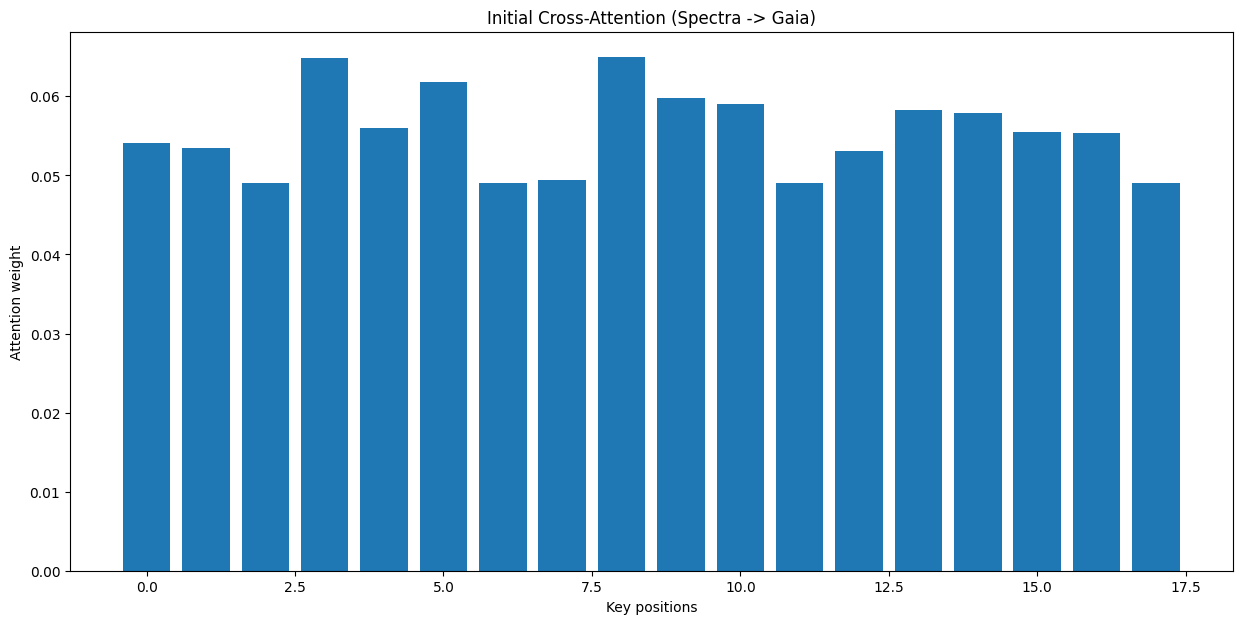

In [30]:
def plot_attention_map_1D(attn_weights, head=0, example=0, title=None):
    attn = attn_weights[example, head].detach().cpu().numpy()
    if attn.ndim == 2 and attn.shape[0] == 1:
        attn = attn[0]  # shape (key_len,)
    # Now attn is 1D
    plt.figure(figsize=(15, 7))
    plt.bar(range(len(attn)), attn)
    plt.title(title if title else "Attention Distribution")
    plt.xlabel("Key positions")
    plt.ylabel("Attention weight")
    plt.show()
plot_attention_map_1D(initial_attn_weights, head=400, example=0, 
                   title="Initial Cross-Attention (Spectra -> Gaia)")

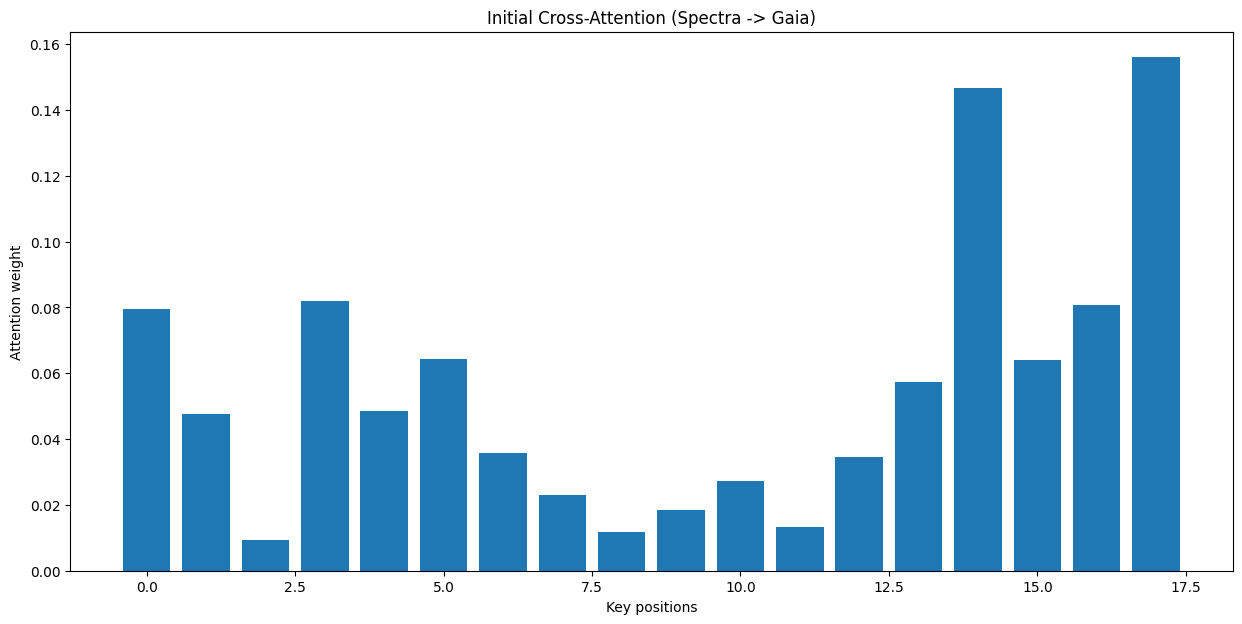

In [21]:
plot_attention_map_1D(final_attn_weights, head=0, example=0, 
                   title="Initial Cross-Attention (Spectra -> Gaia)")

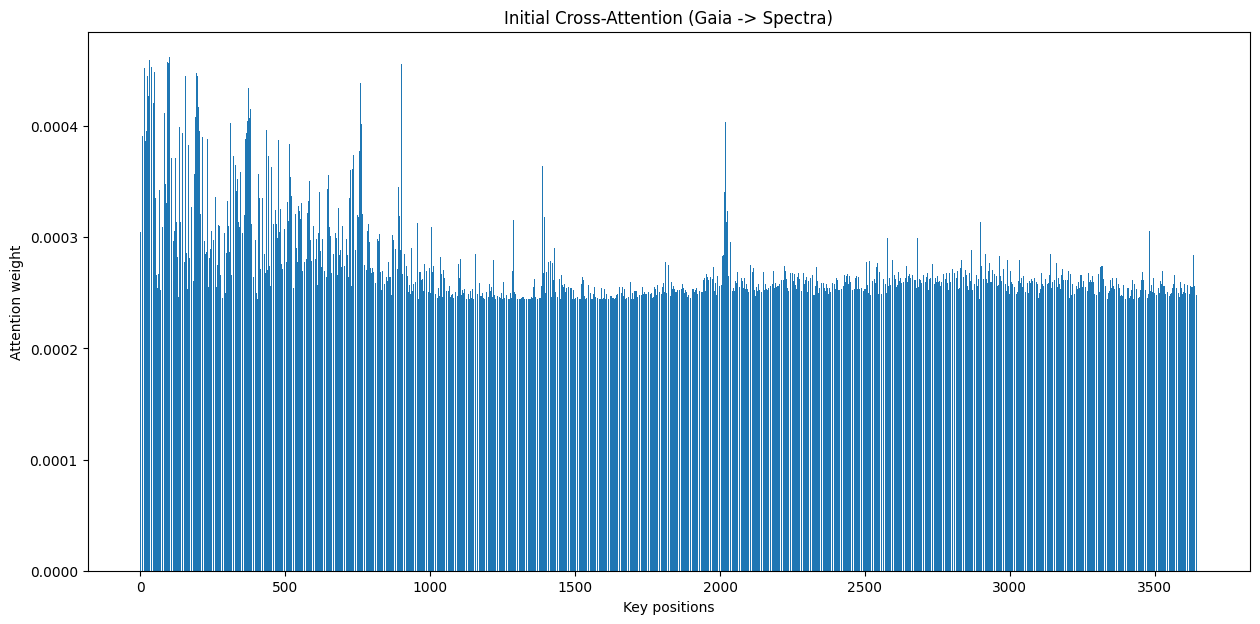

In [22]:
plot_attention_map_1D(initial_attn_gaia, head=0, example=0,
                   title="Initial Cross-Attention (Gaia -> Spectra)")

In [26]:
gaia_columns

['parallax',
 'ra',
 'dec',
 'ra_error',
 'dec_error',
 'parallax_error',
 'pmra',
 'pmdec',
 'pmra_error',
 'pmdec_error',
 'phot_g_mean_flux',
 'flagnopllx',
 'phot_g_mean_flux_error',
 'phot_bp_mean_flux',
 'phot_rp_mean_flux',
 'phot_bp_mean_flux_error',
 'phot_rp_mean_flux_error',
 'flagnoflux']

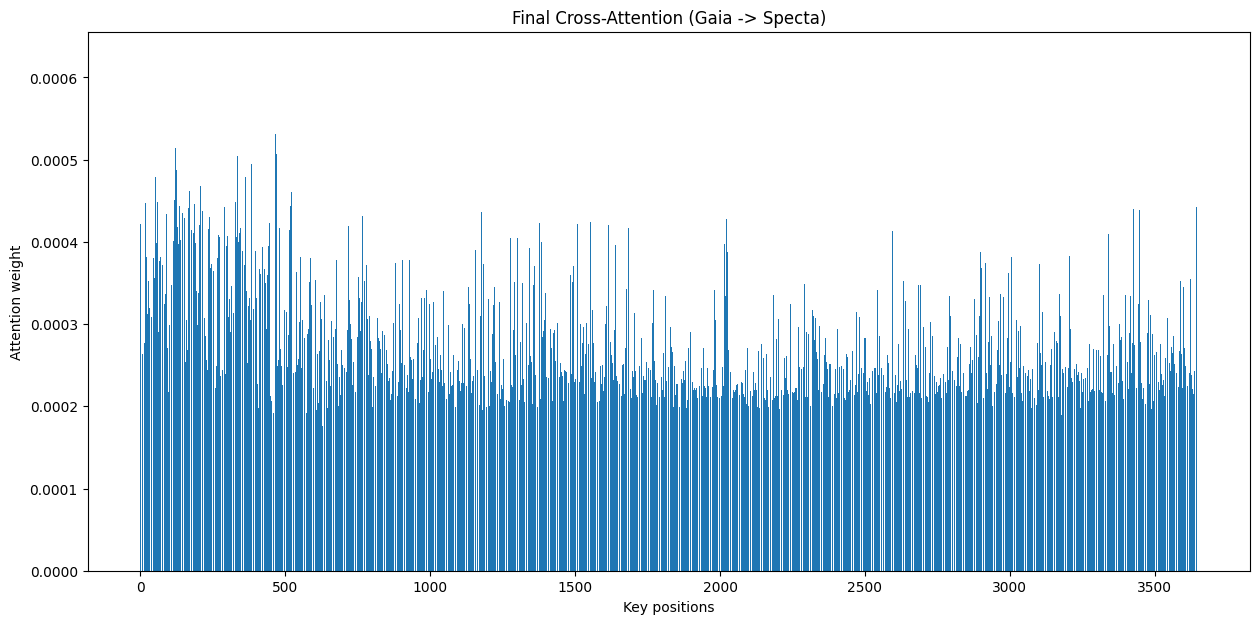

In [29]:
plot_attention_map_1D(final_attn_gaia, head=13, example=0,
                   title="Final Cross-Attention (Gaia -> Specta)")